# Sanchéz sample with TPZ
<span style="font-size: 20px;"> Author: Iago Lopes</span>

<span style="font-size: 16px;">The notebook's objective is trying to replicate the run made in Sanchéz et al 2014 with MAIN sample using TPz.

</span>

### Importing packages

In [1]:
from dblinea import DBBase
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
from astroquery.vizier import Vizier
import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import ascii
from scipy.stats import gaussian_kde
from matplotlib.ticker import FormatStrFormatter

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
db = DBBase()

# Catalog selection
<span style="font-size: 20px;">In this section I try to get all the data used in paper, except for the COSMOS field and the DEEP sample because the data isn't in LIneA server. </span>

## Selecting SDSS/BOSS cross-matched

In [21]:
sdss = pd.read_csv('/home/iago.dias/TPz_notebooks/iago/ml_analyses/Sanchez_Data/SDSS-BOSS.csv')

In [22]:
sdss = sdss[sdss['f_zsp']<40]

In [23]:
sdss = sdss[['RA_ICRS','DE_ICRS','zsp']]
sdss.columns = ['ra','dec','z']

In [24]:
sdss['survey']='SDSS/BOSS'

In [25]:
sdss = sdss[(sdss['ra']>35) & (sdss['ra']<37.5) & (sdss['dec']<-3.5)& (sdss['dec']>-5.7)] 

In [26]:
sdss

,ra,dec,z,survey
229,37.255031,-5.688772,0.95767,SDSS/BOSS
237,37.290464,-5.670331,0.33875,SDSS/BOSS
238,37.437218,-5.675375,0.48237,SDSS/BOSS
239,37.413628,-5.640567,0.08701,SDSS/BOSS
240,37.390754,-5.624758,0.98790,SDSS/BOSS
...,...,...,...,...
1712,35.285733,-3.539826,0.57483,SDSS/BOSS
1713,35.278646,-3.524045,0.55166,SDSS/BOSS
1715,35.510182,-3.567297,0.43385,SDSS/BOSS
1724,35.814534,-3.506449,0.61090,SDSS/BOSS


In [27]:
xlim = [35, 37.6]
ylim = [-5.7, -3.5]
l = 750000
query = f"SELECT alphawin_j2000, deltawin_j2000,ra,dec, extended_class_coadd, mag_auto_g, mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y FROM des_dr2.coadd_objects WHERE q3c_poly_query(ra, dec, ARRAY[{xlim[0]}, {ylim[1]}, {xlim[0]}, {ylim[0]}, {xlim[1]}, {ylim[0]}, {xlim[1]}, {ylim[1]}]) AND extended_class_coadd >= 2 AND mag_auto_g<90 AND mag_auto_r<90 AND mag_auto_i<90 AND mag_auto_z<90 AND mag_auto_y<90 limit {l}"





In [28]:
%%time
df_phot = db.fetchall_df(query)
df_phot

CPU times: user 6.53 s, sys: 1.97 s, total: 8.5 s
Wall time: 2min 52s


,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y
0,35.007487,-5.699908,35.007487,-5.699908,2,26.686527,25.948038,25.431511,24.791912,23.509333,0.753584,0.458936,0.480496,0.543438,0.487275
1,35.007206,-5.698918,35.007206,-5.698918,2,27.243288,27.874516,25.645271,24.257034,23.200809,1.591974,3.312021,0.700980,0.406555,0.448916
2,35.014199,-5.699963,35.014199,-5.699963,3,24.688322,22.845715,21.725687,21.233761,20.832272,0.302786,0.071784,0.041562,0.056253,0.121213
3,35.005710,-5.697600,35.005710,-5.697600,2,25.376404,25.182186,24.695261,23.899033,23.668526,0.403480,0.419228,0.461975,0.438974,1.204582
4,35.005364,-5.696071,35.005364,-5.696071,2,24.941610,24.038229,23.319973,22.473572,21.917591,0.474679,0.282959,0.246103,0.229174,0.446646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478057,37.596972,-3.503949,37.596972,-3.503949,2,28.127264,25.018057,24.558380,23.124821,24.091845,3.914046,0.292783,0.382538,0.181597,1.397011
478058,37.590642,-3.501616,37.590642,-3.501616,2,25.212179,24.898882,25.434877,27.766800,24.401665,0.201906,0.196547,0.658452,10.089209,1.204927
478059,37.596333,-3.501956,37.596333,-3.501956,2,24.835213,24.393511,24.042221,24.025785,22.998522,0.222992,0.185367,0.280440,0.491143,0.603241
478060,37.599093,-3.512776,37.599093,-3.512776,3,22.987028,21.334810,20.564507,20.187857,20.096292,0.059058,0.017016,0.016643,0.020837,0.060350


In [29]:
%%time
coords1 = SkyCoord(ra=df_phot['ra'], dec=df_phot['dec'], unit=(u.deg, u.deg))
coords2 = SkyCoord(ra=sdss['ra'], dec=sdss['dec'], unit=(u.deg, u.deg))


CPU times: user 1min 7s, sys: 550 ms, total: 1min 8s
Wall time: 1min 8s


In [30]:
# Defina um raio de busca (por exemplo, 1 arcsec)
radius = 1 * u.arcsec

# Realize o cruzamento entre os catálogos
# use o método search_around_sky para encontrar objetos coincidentes em um raio
idx1, idx2, d2d, _ = coords1.search_around_sky(coords2, radius)

# idx1 e idx2 contêm os índices dos objetos correspondentes em catalog1 e catalog2
# d2d contém as distâncias angulares entre os objetos correspondentes em arcsec

# Agora você pode usar os índices para acessar os objetos correspondentes em seus catálogos originais
sdss_matched = df_phot.iloc[idx2]
zspec = sdss.iloc[idx1]['z'].values

sdss_matched['z'] = zspec



In [31]:
sdss_matched['survey']='SDSS/BOSS'

In [32]:
sdss_matched

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey
347081,37.255029,-5.688740,37.255029,-5.688740,3,22.149763,22.024118,21.480795,21.265371,21.381197,0.024116,0.029117,0.031689,0.050407,0.187459,0.95767,SDSS/BOSS
357302,37.290511,-5.670288,37.290511,-5.670288,3,20.368042,18.719124,18.175367,17.871948,17.735844,0.012804,0.003618,0.003889,0.005722,0.016731,0.33875,SDSS/BOSS
347462,37.437240,-5.675342,37.437240,-5.675342,3,21.848080,20.027540,19.321104,18.867994,18.668270,0.040691,0.009449,0.009188,0.012096,0.032901,0.48237,SDSS/BOSS
359507,37.413654,-5.640530,37.413654,-5.640530,3,17.227966,16.316692,15.940803,15.656432,15.529766,0.001460,0.000828,0.001053,0.001519,0.004480,0.08701,SDSS/BOSS
359588,37.390743,-5.624734,37.390743,-5.624734,3,22.256493,21.933615,21.404972,21.240953,21.167528,0.024575,0.023864,0.026510,0.043123,0.133044,0.98790,SDSS/BOSS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260310,35.285689,-3.539843,35.285689,-3.539843,3,21.766348,20.213488,19.387247,18.973791,18.866899,0.029791,0.010394,0.008991,0.011265,0.030233,0.57483,SDSS/BOSS
260371,35.278654,-3.524113,35.278654,-3.524113,3,21.742535,19.765615,18.933088,18.531687,18.472466,0.032502,0.007749,0.006445,0.007658,0.021189,0.55166,SDSS/BOSS
261943,35.510185,-3.567325,35.510185,-3.567325,3,21.693323,20.039982,19.464895,19.154772,19.030590,0.029494,0.009056,0.009120,0.012940,0.030145,0.43385,SDSS/BOSS
338158,35.814469,-3.506495,35.814469,-3.506495,3,22.180002,20.395002,19.347071,18.906082,18.829689,0.057846,0.016076,0.010689,0.012002,0.029610,0.61090,SDSS/BOSS


## Selecting 2dFRGS cross-matched

In [33]:
two_d = pd.read_csv('/home/iago.dias/TPz_notebooks/iago/ml_analyses/Sanchez_Data/2dfgrs.csv')

In [34]:
two_d = two_d[two_d['q_z']>=3]

In [35]:
#two_d = two_d[two_d['SNR']>=10] tirar???

In [36]:
two_d = two_d[['RAJ2000','DEJ2000','z']]
two_d.columns=['ra','dec','z']

In [37]:
two_d['survey']='2dFRGS'

In [38]:
two_d = two_d[(two_d['ra']>51.5) & (two_d['ra']<53.9) & (two_d['dec']<-26.9)& (two_d['dec']>-29.2)] 

In [39]:
two_d

,ra,dec,z,survey
890,52.400792,-29.166583,0.2360,2dFRGS
891,52.488417,-29.188250,0.0715,2dFRGS
892,52.522583,-29.162500,0.2830,2dFRGS
893,52.489458,-29.095500,0.1101,2dFRGS
894,52.453292,-29.074472,0.0712,2dFRGS
...,...,...,...,...
2736,51.899750,-26.946694,0.1489,2dFRGS
2737,51.736708,-26.951944,0.1438,2dFRGS
2738,51.721333,-26.928528,0.1433,2dFRGS
2740,51.819292,-26.903333,0.2023,2dFRGS


In [40]:
xlim = [51.5, 53.9]
ylim = [-29.2, -26.9]
l = 750000
query = f"SELECT alphawin_j2000, deltawin_j2000,ra,dec, extended_class_coadd, mag_auto_g, mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y FROM des_dr2.coadd_objects WHERE q3c_poly_query(ra, dec, ARRAY[{xlim[0]}, {ylim[1]}, {xlim[0]}, {ylim[0]}, {xlim[1]}, {ylim[0]}, {xlim[1]}, {ylim[1]}]) AND extended_class_coadd >= 2 AND mag_auto_g<90 AND mag_auto_r<90 AND mag_auto_i<90 AND mag_auto_z<90 AND mag_auto_y<90 limit {l}"




'''
xlim = [51.5, 53.9]
ylim = [-29.2, -26.9]
l = 750000
query = f"SELECT alphawin_j2000, deltawin_j2000,ra,dec, extended_class_coadd, mag_auto_g, mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y FROM des_dr2.coadd_objects WHERE q3c_poly_query(ra, dec, ARRAY[{xlim[0]}, {ylim[1]}, {xlim[0]}, {ylim[0]}, {xlim[1]}, {ylim[0]}, {xlim[1]}, {ylim[1]}]) AND extended_class_coadd >= 2 AND magerr_auto_g<0.103 AND magerr_auto_r<0.103 AND magerr_auto_i<0.103 AND magerr_auto_z<0.103 AND magerr_auto_y<0.103 limit {l}"

'''



'\nxlim = [51.5, 53.9]\nylim = [-29.2, -26.9]\nl = 750000\nquery = f"SELECT alphawin_j2000, deltawin_j2000,ra,dec, extended_class_coadd, mag_auto_g, mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y FROM des_dr2.coadd_objects WHERE q3c_poly_query(ra, dec, ARRAY[{xlim[0]}, {ylim[1]}, {xlim[0]}, {ylim[0]}, {xlim[1]}, {ylim[0]}, {xlim[1]}, {ylim[1]}]) AND extended_class_coadd >= 2 AND magerr_auto_g<0.103 AND magerr_auto_r<0.103 AND magerr_auto_i<0.103 AND magerr_auto_z<0.103 AND magerr_auto_y<0.103 limit {l}"\n\n'

In [41]:
%%time
df_phot_2 = db.fetchall_df(query)
df_phot_2

CPU times: user 5.39 s, sys: 1.11 s, total: 6.5 s
Wall time: 2min 45s


,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y
0,51.500757,-29.199985,51.500757,-29.199985,2,25.021219,26.378838,26.212328,24.512352,24.305445,0.204695,0.954490,1.357094,0.657117,1.697356
1,51.501295,-29.197553,51.501295,-29.197553,2,26.008503,26.700943,24.245358,23.002577,26.348965,0.904676,2.111422,0.364529,0.271298,18.331192
2,51.506612,-29.197664,51.506612,-29.197664,2,24.539690,23.798536,23.513824,23.372150,23.221254,0.165148,0.108295,0.143995,0.283563,0.764117
3,51.503581,-29.195577,51.503581,-29.195577,2,24.023148,23.150806,22.796436,22.622778,22.532957,0.115007,0.061346,0.077828,0.159305,0.391039
4,51.505463,-29.193003,51.505463,-29.193003,2,24.531452,24.634829,24.086082,23.932009,23.945736,0.136475,0.190459,0.190539,0.399125,1.222297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403370,53.892676,-26.902014,53.892676,-26.902014,3,24.433556,23.454012,23.334606,23.082016,23.534523,0.177227,0.090277,0.172789,0.260900,1.239457
403371,53.893548,-26.902633,53.893548,-26.902633,3,22.569305,22.169346,22.023178,21.548998,22.274689,0.033917,0.029367,0.054446,0.066981,0.408751
403372,53.893577,-26.901409,53.893577,-26.901409,3,23.826723,23.338791,22.970352,22.493290,22.262968,0.096593,0.076093,0.117518,0.141011,0.365163
403373,53.897710,-26.902527,53.897710,-26.902527,3,23.837223,23.074015,22.633101,22.525097,22.539566,0.105286,0.065539,0.093143,0.160717,0.509797


In [42]:
%%time
coords1 = SkyCoord(ra=df_phot_2['ra'], dec=df_phot_2['dec'], unit=(u.deg, u.deg))
coords2 = SkyCoord(ra=two_d['ra'], dec=two_d['dec'], unit=(u.deg, u.deg))


CPU times: user 55.9 s, sys: 343 ms, total: 56.2 s
Wall time: 56.2 s


In [43]:
# Defina um raio de busca (por exemplo, 1 arcsec)
radius = 1 * u.arcsec

# Realize o cruzamento entre os catálogos
# use o método search_around_sky para encontrar objetos coincidentes em um raio
idx1, idx2, d2d, _ = coords1.search_around_sky(coords2, radius)

# idx1 e idx2 contêm os índices dos objetos correspondentes em catalog1 e catalog2
# d2d contém as distâncias angulares entre os objetos correspondentes em arcsec

# Agora você pode usar os índices para acessar os objetos correspondentes em seus catálogos originais
two_d_matched = df_phot_2.iloc[idx2]
zspec = two_d.iloc[idx1]['z'].values

two_d_matched['z'] = zspec


In [44]:
two_d_matched['survey']='2dFRGS'

In [45]:
two_d_matched

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey
6055,51.730250,-29.159197,51.730250,-29.159197,3,18.890404,17.888821,17.488638,17.207067,17.112206,0.002955,0.001547,0.001848,0.003098,0.008942,0.1348,2dFRGS
6252,51.726861,-29.100389,51.726861,-29.100389,3,18.832258,17.866297,17.469213,17.193844,17.095108,0.002278,0.001203,0.001443,0.002203,0.005988,0.1168,2dFRGS
5085,51.696841,-29.006400,51.696841,-29.006400,3,18.454252,17.520678,17.126947,16.858967,16.742199,0.002345,0.001446,0.001760,0.002409,0.008960,0.1104,2dFRGS
31515,52.054073,-29.175033,52.054073,-29.175033,3,17.887152,16.835957,16.419085,16.104586,16.013882,0.002141,0.001120,0.001353,0.001739,0.006322,0.1353,2dFRGS
7995,51.958065,-29.163845,51.958065,-29.163845,3,18.077812,17.412390,17.068445,16.878561,16.803955,0.002057,0.001499,0.002073,0.002829,0.010968,0.1496,2dFRGS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217577,51.869277,-27.038115,51.869277,-27.038115,3,18.216961,17.561947,17.258505,17.113890,17.061022,0.002204,0.001572,0.001899,0.003314,0.011871,0.2210,2dFRGS
220616,51.899973,-26.946502,51.899973,-26.946502,3,18.075142,17.309658,16.954515,16.730850,16.650419,0.001843,0.001228,0.001490,0.002580,0.009367,0.1489,2dFRGS
218793,51.736952,-26.951882,51.736952,-26.951882,3,18.326010,17.501541,17.155703,16.918789,16.844782,0.002434,0.001458,0.001655,0.002651,0.010985,0.1438,2dFRGS
218691,51.721499,-26.928319,51.721499,-26.928319,3,17.356909,16.349276,15.953111,15.670392,15.569478,0.001637,0.000858,0.000930,0.001556,0.005874,0.1433,2dFRGS


## Selecting OzDES cross-match

In [46]:
ozdes = pd.read_csv('/home/iago.dias/TPz_notebooks/iago/ml_analyses/Sanchez_Data/OzDES.csv')

In [47]:
ozdes = ozdes[ozdes['types']=='Photo-z'] 

In [48]:
ozdes = ozdes[['RAJ2000','DEJ2000','z']]
ozdes.columns = ['ra','dec','z']

In [49]:
ozdes['survey']='OzDES'

In [50]:
ozdes = ozdes[(ozdes['ra']>51.5) & (ozdes['ra']<53.9) & (ozdes['dec']<-26.9)& (ozdes['dec']>-29.2)] 

In [51]:
ozdes


,ra,dec,z,survey
663,52.364000,-29.063611,0.29499,OzDES
665,52.346208,-29.047444,0.46218,OzDES
666,52.396083,-29.010444,0.21749,OzDES
670,52.340125,-29.003250,0.68351,OzDES
671,52.352750,-28.996944,0.40005,OzDES
...,...,...,...,...
5352,53.552708,-27.018139,0.63642,OzDES
5366,53.478083,-26.959389,0.25218,OzDES
5377,53.263625,-27.083000,0.62159,OzDES
5423,53.811417,-26.921611,0.71457,OzDES


In [52]:
%%time
coords1 = SkyCoord(ra=df_phot_2['ra'], dec=df_phot_2['dec'], unit=(u.deg, u.deg))
coords2 = SkyCoord(ra=ozdes['ra'], dec=ozdes['dec'], unit=(u.deg, u.deg))


CPU times: user 56.8 s, sys: 346 ms, total: 57.2 s
Wall time: 57.2 s


In [53]:
# Defina um raio de busca (por exemplo, 1 arcsec)
radius = 1 * u.arcsec

# Realize o cruzamento entre os catálogos
# use o método search_around_sky para encontrar objetos coincidentes em um raio
idx1, idx2, d2d, _ = coords1.search_around_sky(coords2, radius)

# idx1 e idx2 contêm os índices dos objetos correspondentes em catalog1 e catalog2
# d2d contém as distâncias angulares entre os objetos correspondentes em arcsec

# Agora você pode usar os índices para acessar os objetos correspondentes em seus catálogos originais
ozdes_matched = df_phot_2.iloc[idx2]
zspec = ozdes.iloc[idx1]['z'].values

ozdes_matched['z'] = zspec


In [54]:
ozdes_matched['survey']='OzDES'

In [55]:
ozdes_matched

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey
42399,52.364081,-29.063598,52.364081,-29.063598,3,21.872379,21.204634,20.941463,20.716957,20.862188,0.019739,0.014196,0.020797,0.030582,0.135860,0.29499,OzDES
42237,52.346351,-29.047413,52.346351,-29.047413,3,21.291992,20.458984,20.158737,19.824772,19.539526,0.017564,0.010883,0.014796,0.020341,0.056159,0.46218,OzDES
43076,52.396158,-29.010452,52.396158,-29.010452,3,20.931192,19.781029,19.302427,18.987013,18.862089,0.016878,0.008097,0.009133,0.013398,0.040550,0.21749,OzDES
42689,52.340146,-29.003238,52.340146,-29.003238,3,24.014675,21.947693,20.933828,20.471069,20.311346,0.173799,0.033496,0.023483,0.028881,0.093602,0.68351,OzDES
42989,52.352790,-28.996953,52.352790,-28.996953,3,20.323170,19.225962,18.853956,18.548046,18.512770,0.008102,0.003936,0.004942,0.006943,0.025024,0.40005,OzDES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393137,53.552743,-27.018133,53.552743,-27.018133,3,22.247082,21.135773,20.502247,20.208508,20.062546,0.035119,0.018320,0.019038,0.025469,0.080495,0.63642,OzDES
392951,53.478112,-26.959408,53.478112,-26.959408,3,21.351858,20.625410,20.324642,20.132301,20.138453,0.013876,0.008920,0.012771,0.020135,0.069047,0.25218,OzDES
383639,53.263696,-27.083038,53.263696,-27.083038,3,21.876299,20.946074,20.394661,20.108767,19.970228,0.035056,0.019135,0.022514,0.031080,0.098951,0.62159,OzDES
402591,53.811449,-26.921607,53.811449,-26.921607,3,23.602448,21.813089,20.773027,20.346767,20.302980,0.095374,0.024161,0.018833,0.024319,0.078899,0.71457,OzDES


## Selecting VVDS-DEEP for SN-C3 field and cross-match

In [56]:
vvds_snc3 = pd.read_csv('/home/iago.dias/TPz_notebooks/iago/ml_analyses/Sanchez_Data/VVDS-DEEP-SN-C3.csv')

In [57]:
vvds_snc3 = vvds_snc3[(vvds_snc3['f_z']==3) | (vvds_snc3['f_z']==4)]

In [58]:
vvds_snc3 = vvds_snc3[['RAJ2000','DEJ2000','z']]
vvds_snc3.columns = ['ra','dec','z']
vvds_snc3['survey']='VVDS-DEEP_SNC3'

In [59]:
vvds_snc3 = vvds_snc3[(vvds_snc3['ra']>51.5) & (vvds_snc3['ra']<53.9) & (vvds_snc3['dec']<-26.9)& (vvds_snc3['dec']>-29.2)] 

In [60]:
%%time
coords1 = SkyCoord(ra=df_phot_2['ra'], dec=df_phot_2['dec'], unit=(u.deg, u.deg))
coords2 = SkyCoord(ra=vvds_snc3['ra'], dec=vvds_snc3['dec'], unit=(u.deg, u.deg))


CPU times: user 56.7 s, sys: 295 ms, total: 57 s
Wall time: 57 s


In [61]:
# Defina um raio de busca (por exemplo, 1 arcsec)
radius = 1 * u.arcsec

# Realize o cruzamento entre os catálogos
# use o método search_around_sky para encontrar objetos coincidentes em um raio
idx1, idx2, d2d, _ = coords1.search_around_sky(coords2, radius)

# idx1 e idx2 contêm os índices dos objetos correspondentes em catalog1 e catalog2
# d2d contém as distâncias angulares entre os objetos correspondentes em arcsec

# Agora você pode usar os índices para acessar os objetos correspondentes em seus catálogos originais
vvds_snc3_matched = df_phot_2.iloc[idx2]
zspec = vvds_snc3.iloc[idx1]['z'].values

vvds_snc3_matched['z'] = zspec


In [62]:
vvds_snc3_matched

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z
333217,53.286706,-27.984811,53.286706,-27.984811,3,22.885555,22.217167,22.145771,21.904156,21.562447,0.046603,0.032738,0.060927,0.079103,0.238900,0.3467
332128,53.247478,-27.987065,53.247478,-27.987065,3,25.026497,24.096064,23.688519,22.876402,22.217896,0.255810,0.140685,0.186319,0.150694,0.340404,1.0345
332132,53.250803,-27.982988,53.250803,-27.982988,3,24.444149,22.777306,21.485756,21.053465,20.757029,0.192401,0.053434,0.031655,0.036107,0.111926,0.7323
333292,53.292520,-27.972380,53.292520,-27.972380,3,22.950937,22.229689,22.004982,21.972246,21.978498,0.046543,0.030700,0.049180,0.078952,0.325997,0.5197
333275,53.279024,-27.961066,53.279024,-27.961066,2,23.808512,23.754353,24.381804,23.051592,22.763985,0.098143,0.121461,0.438038,0.214123,0.710239,1.5259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250719,53.060976,-27.635189,53.060976,-27.635189,3,21.260885,20.553328,20.370537,20.112488,20.248232,0.012206,0.008402,0.014201,0.018857,0.091732,0.3272
250295,53.036964,-27.638832,53.036964,-27.638832,3,23.106016,22.539331,22.138922,22.038925,23.397715,0.078851,0.060811,0.076075,0.123214,1.814768,0.6740
250224,53.022457,-27.635440,53.022457,-27.635440,3,22.872257,22.290136,22.190702,22.450642,22.861362,0.051949,0.040210,0.073997,0.172140,0.994070,0.2485
250406,53.040480,-27.629787,53.040480,-27.629787,3,23.036732,22.266546,21.905739,22.112364,21.881971,0.047990,0.030572,0.041672,0.085210,0.301761,0.5575


In [63]:
vvds_snx3 = pd.read_csv('/home/iago.dias/TPz_notebooks/iago/ml_analyses/Sanchez_Data/VVDS-DEEP-SN-X3.csv')

In [64]:
vvds_snx3 = vvds_snx3[(vvds_snx3['f_z']==3) | (vvds_snx3['f_z']==4)]

In [65]:
vvds_snx3 = vvds_snx3[['RAJ2000','DEJ2000','z']]
vvds_snx3.columns = ['ra','dec','z']
vvds_snx3['survey']='VVDS-DEEP_SNX3'

In [66]:
vvds_snx3 = vvds_snx3[(vvds_snx3['ra']>35.4) & (vvds_snx3['ra']<37.9) & (vvds_snx3['dec']<-3.44)& (vvds_snx3['dec']>-5.73)] 

In [67]:
%%time
coords1 = SkyCoord(ra=df_phot['ra'], dec=df_phot['dec'], unit=(u.deg, u.deg))
coords2 = SkyCoord(ra=vvds_snx3['ra'], dec=vvds_snx3['dec'], unit=(u.deg, u.deg))


CPU times: user 1min 7s, sys: 395 ms, total: 1min 8s
Wall time: 1min 8s


In [68]:
# Defina um raio de busca (por exemplo, 1 arcsec)
radius = 1 * u.arcsec

# Realize o cruzamento entre os catálogos
# use o método search_around_sky para encontrar objetos coincidentes em um raio
idx1, idx2, d2d, _ = coords1.search_around_sky(coords2, radius)

# idx1 e idx2 contêm os índices dos objetos correspondentes em catalog1 e catalog2
# d2d contém as distâncias angulares entre os objetos correspondentes em arcsec

# Agora você pode usar os índices para acessar os objetos correspondentes em seus catálogos originais
vvds_snx3_matched = df_phot.iloc[idx2]
zspec = vvds_snx3.iloc[idx1]['z'].values

vvds_snx3_matched['z'] = zspec


In [69]:
vvds_snx3_matched['survey']='VVDS-DEEP_SNX3'

In [70]:
vvds_snx3_matched

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey
184366,36.518960,-4.819177,36.518960,-4.819177,3,22.099041,21.354479,21.198622,21.169971,21.030754,0.028702,0.019255,0.030826,0.056837,0.137146,0.2444,VVDS-DEEP_SNX3
184470,36.560774,-4.821168,36.560774,-4.821168,3,20.901560,20.095232,19.892992,19.644833,19.699436,0.013418,0.008623,0.012344,0.019504,0.059182,0.3826,VVDS-DEEP_SNX3
190457,36.596338,-4.817969,36.596338,-4.817969,3,23.295301,21.644575,20.912897,20.550489,20.514111,0.072464,0.021151,0.019981,0.027077,0.073219,0.5194,VVDS-DEEP_SNX3
190522,36.601075,-4.814174,36.601075,-4.814174,3,24.513222,24.146391,23.556713,23.665051,23.895084,0.181298,0.171516,0.186081,0.388140,1.295122,0.5200,VVDS-DEEP_SNX3
184499,36.581278,-4.819034,36.581278,-4.819034,2,24.514572,24.037298,23.902840,22.944878,22.919243,0.157613,0.132470,0.209533,0.164804,0.433966,0.8025,VVDS-DEEP_SNX3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,36.529195,-4.051856,36.529195,-4.051856,3,23.970829,23.128885,22.021986,21.537502,21.554939,0.125510,0.075660,0.047954,0.071392,0.168510,0.9839,VVDS-DEEP_SNX3
307954,36.429968,-4.059960,36.429968,-4.059960,2,25.257223,24.122269,23.884937,24.088453,24.437765,0.248972,0.113406,0.150168,0.385409,1.324466,0.6913,VVDS-DEEP_SNX3
309374,36.438783,-4.057324,36.438783,-4.057324,3,24.702753,22.872892,22.202976,21.844450,21.811291,0.243529,0.058558,0.052097,0.085259,0.198299,0.4278,VVDS-DEEP_SNX3
309401,36.447076,-4.049981,36.447076,-4.049981,3,23.412895,22.774393,22.617565,22.654896,23.331470,0.078655,0.056495,0.087659,0.191226,0.822601,0.5394,VVDS-DEEP_SNX3


## Selecting ACES cross-matched

```sql
SELECT * 
FROM des_dr2.public_pz_training_set 
WHERE survey = 'ACES'
```

In [71]:

query_matched = "SELECT * FROM des_dr2.public_pz_training_set WHERE survey = 'ACES'"




In [72]:
df_matched = db.fetchall_df(query_matched)

In [73]:


df_matched = df_matched[(df_matched['mag_auto_g_dered']<90) & (df_matched['mag_auto_r_dered']<90) &(df_matched['mag_auto_i_dered']<90) &(df_matched['mag_auto_z_dered']<90) &(df_matched['mag_auto_y_dered']<90)]




In [74]:


#df_matched = df_matched[(df_matched['magerr_auto_g']<0.103) & (df_matched['magerr_auto_r']<0.103) &(df_matched['magerr_auto_i']<0.103) &(df_matched['magerr_auto_z']<0.103) &(df_matched['magerr_auto_y']<0.103)]




In [75]:
df_matched.columns=['coadd_object_id','ra','dec','z','err_z','flag_des','survey','flag','mag_auto_g','mag_auto_r','mag_auto_i','mag_auto_z','mag_auto_y','magerr_auto_g','magerr_auto_r','magerr_auto_i','magerr_auto_z','magerr_auto_y']

In [76]:

aces_matched = df_matched[df_matched['survey']=='ACES']

# Preparing and saving data

## Combining all catalogs as in paper 


### Main training sample

In [77]:
random = 7
training_1 = vvds_snx3_matched.sample(int(len(vvds_snx3_matched)/2),random_state=random)
training_2 = sdss_matched.sample(int(len(sdss_matched)/2),random_state=random) 
training_3 = aces_matched.sample(int(len(aces_matched)/2),random_state=random)
training_4 = two_d_matched.sample(int(len(two_d_matched)/2),random_state=random)
training_5 = ozdes_matched.sample(int(len(ozdes_matched)/2),random_state=random)

In [78]:
print(len(vvds_snx3_matched))
print(len(sdss_matched))
print(len(aces_matched))
print(len(two_d_matched))
print(len(ozdes_matched))

4302
739
3913
453
744


In [80]:
training = pd.concat([training_2,training_3,training_4,training_5,training_1],axis=0)

In [81]:
training = training.sort_values(by = 'z')

In [82]:
training

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,...,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey,coadd_object_id,err_z,flag_des,flag
83704,51.526267,-28.043012,51.526267,-28.043012,2.0,21.863148,20.544191,19.367323,18.775034,18.179514,...,0.010915,0.006911,0.007443,0.017537,-0.00004,OzDES,NaN,NaN,NaN,NaN
316301,53.710307,-28.705020,53.710307,-28.705020,3.0,21.699507,20.888487,20.279921,19.968479,19.947905,...,0.014318,0.016840,0.018135,0.091048,0.00001,OzDES,NaN,NaN,NaN,NaN
280962,53.413018,-28.957184,53.413018,-28.957184,3.0,16.346836,15.746872,15.518516,15.381664,15.334456,...,0.000958,0.001431,0.002120,0.009711,0.00580,2dFRGS,NaN,NaN,NaN,NaN
202617,36.486117,-4.315873,36.486117,-4.315873,3.0,14.684835,14.142262,13.914722,13.712691,13.578382,...,0.000231,0.000311,0.000502,0.001201,0.01880,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
192696,36.787422,-4.811946,36.787422,-4.811946,3.0,21.639528,21.137905,20.967508,20.817793,20.580000,...,0.018181,0.029483,0.047513,0.114295,0.03070,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209493,36.674124,-4.325438,36.674124,-4.325438,3.0,23.251837,22.818235,22.780270,22.752371,23.038912,...,0.051333,0.089595,0.165025,0.615493,2.71590,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
183157,36.364453,-4.711258,36.364453,-4.711258,2.0,23.873705,23.322233,23.284674,23.065578,22.457058,...,0.071387,0.123028,0.188292,0.338342,2.85670,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
374330,37.275208,-5.241354,37.275208,-5.241354,2.0,20.531601,20.332012,20.505495,20.284128,20.153481,...,0.006661,0.013259,0.022100,0.062951,3.17391,SDSS/BOSS,NaN,NaN,NaN,NaN
210738,36.755125,-4.351286,36.755125,-4.351286,2.0,24.906641,23.690594,23.832243,22.709246,21.277733,...,0.125602,0.257667,0.195300,0.131354,3.27800,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN


### Main testing sample

In [83]:
testing_1 = vvds_snx3_matched.drop(training_1.index)
testing_2 = sdss_matched.drop(training_2.index)
testing_3 = aces_matched.drop(training_3.index)
testing_4 = two_d_matched.drop(training_4.index)
testing_5 = ozdes_matched.drop(training_5.index)

In [84]:
testing = pd.concat([testing_2,testing_3,testing_4,testing_5,vvds_snc3_matched,testing_1],axis=0)

In [85]:
testing = testing.sort_values(by = 'z')

In [86]:
testing

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,...,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey,coadd_object_id,err_z,flag_des,flag
30345,51.962026,-28.544130,51.962026,-28.544130,3.0,16.622868,15.669712,15.913943,15.761472,15.124874,...,0.000237,0.000390,0.000532,0.001139,-0.00070,2dFRGS,NaN,NaN,NaN,NaN
325838,53.352548,-28.058769,53.352548,-28.058769,3.0,20.806368,19.346584,18.447672,18.053997,17.991480,...,0.003026,0.002643,0.003058,0.012056,-0.00006,OzDES,NaN,NaN,NaN,NaN
187759,52.675018,-27.975026,52.675018,-27.975026,3.0,20.633921,19.122152,18.121801,17.705368,17.611238,...,0.002589,0.001860,0.002007,0.007754,-0.00004,OzDES,NaN,NaN,NaN,NaN
79618,53.081516,-28.865740,53.081516,-28.865740,2.0,21.384100,20.360123,19.561579,19.209375,19.193346,...,0.007098,0.006384,0.007643,0.034540,-0.00004,OzDES,NaN,NaN,NaN,NaN
218350,35.098977,-3.677724,35.098977,-3.677724,3.0,19.667759,19.901161,19.784492,19.502771,19.498690,...,0.005759,0.008029,0.011991,0.039413,0.00034,SDSS/BOSS,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412124,36.976917,-4.443876,36.976917,-4.443876,2.0,23.556133,22.419399,22.348719,22.428991,22.192705,...,0.037759,0.066800,0.131534,0.280436,3.83520,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
210960,36.748405,-4.309199,36.748405,-4.309199,2.0,25.378403,23.944036,23.869860,23.726408,24.136190,...,0.106292,0.173879,0.326869,1.195571,3.87250,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
303991,36.321056,-4.153834,36.321056,-4.153834,2.0,25.026150,24.443306,24.046165,23.238583,22.852564,...,0.180906,0.224087,0.202039,0.361398,4.08260,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
115790,36.489088,-5.438917,36.489088,-5.438917,3.0,21.507210,21.262779,21.195372,20.660839,20.592855,...,0.025053,0.040199,0.047329,0.121931,6.56176,SDSS/BOSS,NaN,NaN,NaN,NaN


In [ ]:
plt.scatter(testing['mag_auto_g']-testing['mag_auto_r'],testing['mag_auto_r']-testing['mag_auto_i'],color='black',s=0.4)
plt.scatter(training['mag_auto_g']-training['mag_auto_r'],training['mag_auto_r']-training['mag_auto_i'],s=0.4)

## Saving the data according to the TPz requiriments

In [ ]:
del testing['coadd_object_id'], testing['survey'], testing['err_z'], testing['flag'], testing['flag_des'], testing['ra'], testing['dec'], testing['alphawin_j2000'],testing['deltawin_j2000'],testing['extended_class_coadd']
del training['coadd_object_id'], training['survey'], training['err_z'], training['flag'], training['flag_des'], training['ra'], training['dec'], training['alphawin_j2000'],training['deltawin_j2000'],training['extended_class_coadd']


In [ ]:
last_column = training.columns[-1]
training = training[[last_column] + [column for column in training.columns if column != last_column]]

last_column2 = testing.columns[-1]
testing = testing[[last_column2] + [column for column in training.columns if column != last_column2]]

In [ ]:
g = testing['mag_auto_g']
r = testing['mag_auto_r']
i = testing['mag_auto_i']
z = testing['mag_auto_z']
y = testing['mag_auto_y']
gt = training['mag_auto_g']
rt = training['mag_auto_r']
it = training['mag_auto_i']
zt = training['mag_auto_z']
yt = training['mag_auto_y']

testing['g-r'] = g-r
testing['r-i'] = r-i
testing['i-z'] = i-z
testing['z-y'] = z-y
training['g-r'] = gt-rt
training['r-i'] = rt-it
training['i-z'] = it-zt
training['z-y'] = zt-yt

In [ ]:
testing.columns = ['#zs','g','r','i','z','y','eg','er','ei','ez','ey','g-r','r-i','i-z','z-y']
training.columns = ['#zs','g','r','i','z','y','eg','er','ei','ez','ey','g-r','r-i','i-z','z-y']

In [ ]:
testing['eg-r'] = testing['eg']-testing['er']
testing['er-i'] = testing['er']-testing['ei']
testing['ei-z'] = testing['ei']-testing['ez']
testing['ez-y'] = testing['ez']-testing['ey']
training['eg-r'] = training['eg']-training['er']
training['er-i'] = training['er']-training['ei']
training['ei-z'] = training['ei']-training['ez']
training['ez-y'] = training['ez']-training['ey']

In [ ]:
testing.to_csv('/home/iago.dias/TPz_notebooks/iago/ml_analyses/samples/validation.sanchez.0', sep=' ', index = False)
training.to_csv('/home/iago.dias/TPz_notebooks/iago/ml_analyses/samples/training.sanchez.0', sep=' ', index = False)

In [ ]:
testing

# Previous plots inspired in paper

## Functions for plots

In [18]:
def histogram_zspec(catalog,column_name):
    plt.figure(figsize=(10,10))
    r = plt.hist(catalog[column_name], bins = 15,color='red')#,histtype='step')
    plt.xlim(0,1.4)
    plt.yticks([500,1000,1500,2000,2500,3000])
    plt.xlabel('Zspec')
    plt.ylabel('Contagem')

In [16]:
def sn_mag(catalog):
    i=1
    plt.figure(figsize=(10,10))
    for band in ['g','r','i','z']:
        plt.subplot(2,2,i)
        sn = 1/(10**(0.4*catalog[f'magerr_auto_{band}'])-1)
        plt.scatter(catalog[f'mag_auto_{band}'], sn,color = 'red',s=2)
        plt.xlim(21,25)
        plt.ylim(0,60)
        plt.title(f'{band} magnitude')
        plt.xticks([21.5,22.5,23.5,24.5])
        i+=1

## Plots

In [ ]:
sn_mag(dr2_sample)

In [19]:
main = pd.concat([testing,training],axis=0)
main = main[main['#zs']<1.4]

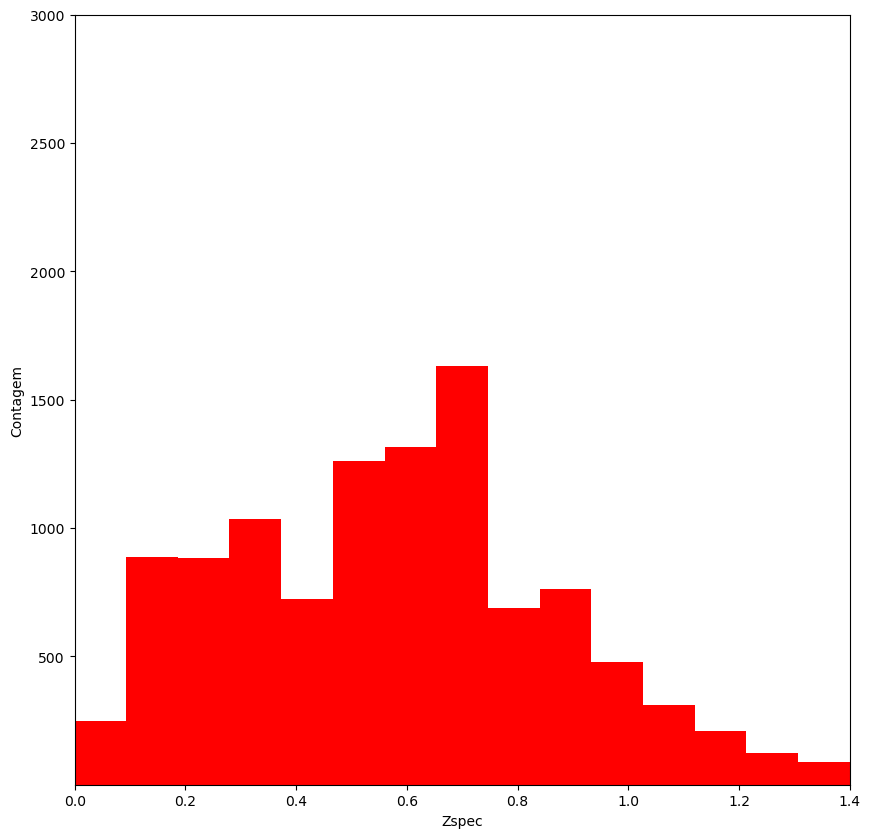

In [20]:
histogram_zspec(main,'#zs')

# Results analyses

Choose the result file for analyses

In [4]:

column_names = ['ztrue','zmode0','zmean1','zConf0','zConf1','err0','err1']
df = pd.read_csv('/home/iago.dias/TPz_notebooks/iago/ml_analyses/samples/results/results.DR2.1.mlz',names = column_names, header = None, skiprows =1, sep =' ')

zspec=df['ztrue']
zphot = df['zmean1']


## Phot sample for weighting 

```sql

SELECT alphawin_j2000, deltawin_j2000,ra,dec, mag_auto_g, mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y FROM des_dr2.coadd_objects WHERE mag_auto_i>18 AND mag_auto_i<24 AND mag_auto_g-mag_auto_r BETWEEN 0 AND 2 AND mag_auto_r-mag_auto_i BETWEEN 0 AND 2 AND extended_class_coadd >= 2 AND mag_auto_g<90 AND mag_auto_r<90 AND mag_auto_i<90 AND mag_auto_z<90 AND mag_auto_y<90 ORDER BY RANDOM() LIMIT {l} 

 
```


In [5]:

l = 25000
query_sanchez_dr2 = f"SELECT alphawin_j2000, deltawin_j2000,ra,dec, mag_auto_g, mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y FROM des_dr2.coadd_objects WHERE mag_auto_i>18 AND mag_auto_i<24 AND mag_auto_g-mag_auto_r BETWEEN 0 AND 2 AND mag_auto_r-mag_auto_i BETWEEN 0 AND 2 AND extended_class_coadd >= 2 AND mag_auto_g<90 AND mag_auto_r<90 AND mag_auto_i<90 AND mag_auto_z<90 AND mag_auto_y<90 ORDER BY RANDOM() LIMIT {l} "



```sql
SELECT erdr2_sample_image, ra, dec, extended_class_coadd, mag_auto_g, mag_auto_r, mag_auto_i, mag_auto_z, mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y 
FROM des_dr2.coadd_objects 
WHERE extended_class_coadd>=2 AND flags_g<4 AND flags_r<4 AND flags_i<4 AND flags_z<4 AND flags_y<4 AND mag_auto_i_dered>16 AND mag_auto_r_dered>16 AND mag_auto_g_dered - mag_auto_r_dered BETWEEN -1 AND 4 AND mag_auto_r_dered - mag_auto_i_dered BETWEEN -1 AND 4 AND mag_auto_i_dered - mag_auto_z_dered BETWEEN -1 AND 4 AND magerr_auto_g<0.1086 AND magerr_auto_r<0.1086 AND magerr_auto_i<0.1086 AND magerr_auto_z<0.1086 AND magerr_auto_y<0.1086 ORDER BY RANDOM() LIMIT 100000;



```

In [6]:


query_dr2_spec_catalog = "SELECT erra_image, ra, dec, extended_class_coadd, mag_auto_g, mag_auto_r, mag_auto_i, mag_auto_z, mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y FROM des_dr2.coadd_objects WHERE extended_class_coadd>=2 AND flags_g<4 AND flags_r<4 AND flags_i<4 AND flags_z<4 AND flags_y<4 AND mag_auto_i_dered>16 AND mag_auto_r_dered>16 AND mag_auto_g_dered - mag_auto_r_dered BETWEEN -1 AND 4 AND mag_auto_r_dered - mag_auto_i_dered BETWEEN -1 AND 4 AND mag_auto_i_dered - mag_auto_z_dered BETWEEN -1 AND 4 AND magerr_auto_g<0.1086 AND magerr_auto_r<0.1086 AND magerr_auto_i<0.1086 AND magerr_auto_z<0.1086 AND magerr_auto_y<0.1086 ORDER BY RANDOM() LIMIT 100000;"




In [7]:
%%time
###### FOR SPEC CATALOG #######
#origin = db.fetchall_df(query_dr2_spec_catalog)
#dr2_sample = origin
dr2_sample = pd.read_csv('/home/iago.dias/TPz_notebooks/iago/ml_analyses/samples/phot_sample_weighting_GAMA_VIPERS_VVDS.csv', sep =' ') # data saved


####### FOR SANCHEZ #######
#dr2_sample = db.fetchall_df(query_sanchez_dr2)
#dr2_sample = pd.read_csv('/home/iago.dias/TPz_notebooks/iago/ml_analyses/samples/phot_sample_weighting_GAMA_VIPERS_VVDS.csv', sep =' ') # data saved

CPU times: user 335 ms, sys: 57.6 ms, total: 393 ms
Wall time: 390 ms


## Functions for analyses

In [8]:
def plot_scatter(zspec,zphot):
    # Calcula a estimativa de densidade usando kernel
    kde = gaussian_kde([zspec, zphot])

    # Define os limites do gráfico
    x_min, x_max = min(zspec), max(zspec)
    y_min, y_max = min(zphot), max(zphot)
    
    # Cria uma grade de valores para o gráfico
    x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    z = kde(np.vstack([x.ravel(), y.ravel()]))
    plt.figure(figsize=(8,6))


    plt.plot(zspec,zspec,'r--', linewidth =0.5)


    plt.contourf(x, y, z.reshape(x.shape), cmap='turbo', levels=100)
    colorbar = plt.colorbar()
    colorbar.set_label('Density', fontsize=20)

    plt.xlim(0, max(zphot))
    plt.ylim(0, max(zphot))

    plt.xlabel(r'$z_{spec}$', fontsize=22)
    plt.ylabel(r'$z_{phot}$',fontsize=22)

    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)


    plt.show()

In [45]:
def plot_metrics(zspec,zphot,maximum=round(max(zphot),1)):
    
    bins = np.arange(0.0, maximum, 0.1)
    points = bins+0.05
    fraction_outliers = []
    sigma68z = []
    sigmaz=[]
    meanz = []
    outliers_2 = []

    for index in range(len(bins) - 1):
        bin_lower = bins[index]
        bin_upper = bins[index + 1]
    
        values_r = zphot[(zphot >= bin_lower) & (zphot <= bin_upper)]
        values_s = zspec[(zphot >= bin_lower) & (zphot <= bin_upper)]
        
        

        deltabias = (values_r - values_s)
        mean_bias = np.mean(deltabias)  # Mean bias for each bin
        meanz.append(mean_bias)
        
        
    
        s = np.sort(np.abs(deltabias/(1+values_s)))  # Standard deviation (sigma) for each bin
        sigma68 = s[int(len(s)*0.68)]
        sigma68z.append(sigma68)
        
        
        
        sigma = (np.sum((values_r-values_s-mean_bias)**2)/len(values_r))**0.5
        sigmaz.append(sigma)
    
        # Calculate the fraction of outliers outside 3 sigma
        outliers = deltabias[np.abs(deltabias-mean_bias) > 3 * sigma]
        fraction_outlier = len(outliers) / len(deltabias)
        fraction_outliers.append(fraction_outlier)
        
        
    
        #2 sigma
        outliers2 = deltabias[np.abs(deltabias-mean_bias) > 2 * sigma]
        fraction_outlier2 = len(outliers2) / len(deltabias)
        outliers_2.append(fraction_outlier2)



    fig, axes = plt.subplots(4, 1, figsize=(8, 14), sharex=True)
    plt.subplots_adjust(hspace=0.001)  # Ajuste o espaço entre os subplots

    # Configure os limites x comuns para todos os subplots
    x_lim = (0, np.max(bins))

    # Subplot 1: Mean Bias
    axes[0].plot(points[:-1], meanz, 'bo-')
    axes[0].axhline(0, color='black', linestyle='--')
    axes[0].set_ylabel(r'$\Delta z$', fontsize=20)
    axes[0].set_xlim(x_lim)
    axes[0].tick_params(axis='both', labelsize=14)
    axes[0].grid(True)

    # Subplot 2: Sigma 68
    axes[1].plot(points[:-1], sigma68z, 'go-')
    axes[1].set_ylabel(r'$\sigma_{68}$', fontsize=20)
    axes[1].set_xlim(x_lim)
    axes[1].axhline(0.12, color='black', linestyle='--')
    axes[1].set_ylim(0,max(sigmaz)+0.01)
    #axes[1].set_ylim(0, 0.4)
    #axes[1].set_yticks(np.arange(0, 0.5, 0.05))
    axes[1].tick_params(axis='both', labelsize=14)
    axes[1].grid(True)


    # Subplot3: 2_outliers
    axes[2].plot(points[:-1],outliers_2,'o-',color='darkorange')
    #axes[2].set_xlabel(r'$Z_{phot}$', fontsize=20)
    axes[2].set_ylabel('out$_{2σ}$', fontsize=20)
    axes[2].set_xlim(x_lim)
    #axes[2].set_ylim(0,max(outliers_2)+0.01)
    axes[2].axhline(0.1, color='black', linestyle='--')
    axes[2].tick_params(axis='both', labelsize=14)
    axes[2].grid(True)
    axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Subplot 4: 3_outliers
    axes[3].plot(points[:-1], fraction_outliers, 'ro-')
    axes[3].set_xlabel(r'$Z_{phot}$', fontsize=20)
    axes[3].set_ylabel('out$_{3σ}$', fontsize=20)
    axes[3].set_xlim(x_lim)
    axes[3].set_ylim(0,max(fraction_outliers)+0.01)
    axes[3].axhline(0.015, color='black', linestyle='--')
    axes[3].tick_params(axis='both', labelsize=14)
    axes[3].grid(True)


    plt.xlim(0,points[-1])
    # Ajuste o layout dos subplots
    plt.tight_layout()
    plt.savefig('/home/iago.dias/TPz_notebooks/metrics.png')

    # Exiba a figura
    plt.show()


In [10]:
def metrics(zspec,zphot):
    meanz = np.mean(zphot-zspec)
    sigmaz = (np.sum((zphot-zspec-meanz)**2)/len(zphot))**0.5
    s = np.sort(np.abs((zphot-zspec)/(1+zspec)))
    sigmaz68 = s[int(len(s)*0.68)]
    fraction3 = len(zphot[np.abs((zphot-zspec-meanz))>3*sigmaz])/len(zphot)
    fraction2 = len(zphot[np.abs(zphot-zspec-meanz)>2*sigmaz])/len(zphot)
    
    print(f'Mean   : {meanz}\n')
    print(f'Sigma  : {sigmaz}\n')
    print(f'Sigma68: {sigmaz68}\n')
    print(f'Out_3  : {fraction3}\n')
    print(f'Out_2  : {fraction2}')

In [17]:

def weighting(n_near, phot, train):
    train['weight'] = 0.0

    phot_data = phot[['mag_auto_g', 'mag_auto_r', 'mag_auto_i', 'mag_auto_z', 'mag_auto_y']].values
    train_data = train[['mag_auto_g', 'mag_auto_r', 'mag_auto_i', 'mag_auto_z', 'mag_auto_y']].values

    for galaxy in tqdm(range(len(train_data))):
        diff = train_data - train_data[galaxy]
        dist = np.sum(diff**2, axis=1)

        nearest = np.argpartition(dist, n_near)[:n_near]
        max_dist = max(dist[nearest])

        top = train_data[galaxy] + np.sqrt(max_dist / 5)
        bottom = train_data[galaxy] - np.sqrt(max_dist / 5)

        n_phot = 0

        for obj in phot_data:
            condition = all(bottom <= obj) and all(obj <= top)
            if condition:
                n_phot += 1

        weight = n_phot / (n_near * len(phot))
        train.at[train.index[galaxy], 'weight'] = weight

    return train


'''def weighting(n_near,phot,train):
    
    #train = train[((train['mag_auto_g']-train['mag_auto_r'])<2) & ((train['mag_auto_g']-train['mag_auto_r'])>0) & ((train['mag_auto_r']-train['mag_auto_i'])<2) & ((train['mag_auto_r']-train['mag_auto_i'])>0) & (train['mag_auto_i']<24) & (train['mag_auto_i']>18)]

    train['weight']=0.0
    vector_phot = np.array([phot['mag_auto_g'],phot['mag_auto_r'],phot['mag_auto_i'],phot['mag_auto_z'],phot['mag_auto_y']])
    vector_phot = vector_phot.T
    vector_train = np.array([train['mag_auto_g'],train['mag_auto_r'],train['mag_auto_i'],train['mag_auto_z'],train['mag_auto_y']])
    vector_train = vector_train.T

    for galaxy in tqdm(range(len(vector_train))):
        diff = vector_train-vector_train[galaxy]
        dist = np.sum(diff**2, axis=1)
        
        
        nearest = np.argsort(dist)[:n_near]
        max_dist = max(dist[nearest])

        
        top = vector_train[galaxy] + np.sqrt(max_dist/5)
        bottom = vector_train[galaxy] - np.sqrt(max_dist/5)
        
        # Looking for N of photometric galaxies that are in volume defined by max dist
        n_phot=0
        for index in range(len(vector_phot)):
            obj = vector_phot[index]
            condition = (obj[0]<top[0]) & (obj[1]<top[1]) & (obj[2]<top[2]) & (obj[3]<top[3]) & (obj[4]<top[4]) & (obj[0]>bottom[0]) & (obj[1]>bottom[1]) & (obj[2]>bottom[2]) & (obj[3]>bottom[3]) & (obj[4]>bottom[4])
            if condition:
                n_phot+=1
            else:
                None
                
                
        weight = n_phot/(n_near*len(phot))
        
        train.at[train.index[galaxy], 'weight']=weight
    return train'''

"def weighting(n_near,phot,train):\n    \n    #train = train[((train['mag_auto_g']-train['mag_auto_r'])<2) & ((train['mag_auto_g']-train['mag_auto_r'])>0) & ((train['mag_auto_r']-train['mag_auto_i'])<2) & ((train['mag_auto_r']-train['mag_auto_i'])>0) & (train['mag_auto_i']<24) & (train['mag_auto_i']>18)]\n\n    train['weight']=0.0\n    vector_phot = np.array([phot['mag_auto_g'],phot['mag_auto_r'],phot['mag_auto_i'],phot['mag_auto_z'],phot['mag_auto_y']])\n    vector_phot = vector_phot.T\n    vector_train = np.array([train['mag_auto_g'],train['mag_auto_r'],train['mag_auto_i'],train['mag_auto_z'],train['mag_auto_y']])\n    vector_train = vector_train.T\n\n    for galaxy in tqdm(range(len(vector_train))):\n        diff = vector_train-vector_train[galaxy]\n        dist = np.sum(diff**2, axis=1)\n        \n        \n        nearest = np.argsort(dist)[:n_near]\n        max_dist = max(dist[nearest])\n\n        \n        top = vector_train[galaxy] + np.sqrt(max_dist/5)\n        bottom = vector

In [12]:
def recalculation(n_near,phot,train,w_min):
    modified_w = []
    low_w = train[train['weight']>w_min]
    
    vector_phot = np.array([phot['mag_auto_g'],phot['mag_auto_r'],phot['mag_auto_i'],phot['mag_auto_z'],phot['mag_auto_y']])
    vector_phot = vector_phot.T
    vector_train = np.array([low_w['mag_auto_g'],low_w['mag_auto_r'],low_w['mag_auto_i'],low_w['mag_auto_z'],low_w['mag_auto_y']])
    vector_train = vector_train.T
    
    for galaxy in tqdm(range(len(vector_train))):
        diff = vector_train-vector_train[galaxy]
        dist = np.sum(diff**2, axis=1)
        
        nearest = np.argsort(dist)[:n_near]
        max_dist = max(dist[nearest])
        
        top = vector_train[galaxy] + np.sqrt(max_dist/5)
        bottom = vector_train[galaxy] - np.sqrt(max_dist/5)
        
        # Looking for N of photometric galaxies that are in volume defined by max dist
        n_phot=0
        for index in range(len(vector_phot)):
            obj = vector_phot[index]
            condition = (obj[0]<top[0]) & (obj[1]<top[1]) & (obj[2]<top[2]) & (obj[3]<top[3]) & (obj[4]<top[4]) & (obj[0]>bottom[0]) & (obj[1]>bottom[1]) & (obj[2]>bottom[2]) & (obj[3]>bottom[3]) & (obj[4]>bottom[4])
            if condition:
                n_phot+=1
            else:
                None
                
        weight = n_phot/(n_near*len(phot))
        
        train.at[train.index[galaxy], 'weight']=weight
    
        
    return train

In [46]:
def plot_metrics_weight(zspec,zphot,w,maximum=round(max(zphot),1)):
    
    bins = np.arange(0.0, maximum, 0.1)
    points = bins+0.05
    fraction_outliers = []
    sigma68z = []
    sigmaz=[]
    meanz = []
    outliers_2 = []
    w = np.array(w['weight'])


    for index in range(len(bins) - 1):
        bin_lower = bins[index]
        bin_upper = bins[index + 1]
    
        values_r = zphot[(zphot >= bin_lower) & (zphot <= bin_upper)]
        values_s = zspec[(zphot >= bin_lower) & (zphot <= bin_upper)]
        w_bin = w[(zphot >= bin_lower) & (zphot <= bin_upper)]

        
        
        deltabias = (values_r - values_s)
        mean_bias = np.sum(w_bin*deltabias)/np.sum(w_bin)  # Mean bias for each bin
        meanz.append(mean_bias)
        
        
    
        s = np.sort(np.abs(deltabias/(1+values_s)))  # Standard deviation (sigma) for each bin
        sigma68 = s[int(len(s)*0.68)]
        sigma68z.append(sigma68)
        
        

        sigma = (np.sum(w_bin*(values_r-values_s-mean_bias)**2)/np.sum(w_bin))**0.5
        sigmaz.append(sigma)
    
    
    
        # Calculate the fraction of outliers outside 3 sigma
        outliers = deltabias[np.abs(deltabias-mean_bias) > 3 * sigma]
        fraction_outlier = len(outliers) / len(deltabias)
        fraction_outliers.append(fraction_outlier)
    
    
    
        #2 sigma
        outliers2 = deltabias[np.abs(deltabias-mean_bias) > 2 * sigma]
        fraction_outlier2 = len(outliers2) / len(deltabias)
    
    
        outliers_2.append(fraction_outlier2)



    fig, axes = plt.subplots(4, 1, figsize=(8, 14), sharex=True)
    plt.subplots_adjust(hspace=0.001)  # Ajuste o espaço entre os subplots

    # Configure os limites x comuns para todos os subplots
    x_lim = (0, np.max(zphot))

    # Subplot 1: Mean Bias
    axes[0].plot(points[:-1], meanz, 'bo-')
    axes[0].axhline(0, color='black', linestyle='--')
    axes[0].set_ylabel(r'$\Delta z$', fontsize=20)
    axes[0].set_xlim(x_lim)
    axes[0].tick_params(axis='both', labelsize=14)
    axes[0].grid(True)

    # Subplot 2: Standard Deviation
    axes[1].plot(points[:-1], sigma68z, 'go-')
    axes[1].set_ylabel(r'$\sigma_{68}$', fontsize=20)
    axes[1].set_xlim(x_lim)
    axes[1].axhline(0.12, color='black', linestyle='--')
    axes[1].set_ylim(0,max(sigmaz)+0.01)
    axes[1].tick_params(axis='both', labelsize=14)
    axes[1].grid(True)


    # Subplot3: outlier
    axes[2].plot(points[:-1],outliers_2,'o-',color='darkorange')
    #axes[2].set_xlabel(r'$Z_{phot}$', fontsize=20)
    axes[2].set_ylabel('out$_{2σ}$', fontsize=20)
    axes[2].set_xlim(x_lim)
    #axes[2].set_ylim(0,max(outliers_2)+0.01)
    axes[2].axhline(0.1, color='black', linestyle='--')
    axes[2].tick_params(axis='both', labelsize=14)
    axes[2].grid(True)
    axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Subplot 4: Outliers
    axes[3].plot(points[:-1], fraction_outliers, 'ro-')
    axes[3].set_xlabel(r'$Z_{phot}$', fontsize=20)
    axes[3].set_ylabel('out$_{3σ}$', fontsize=20)
    axes[3].set_xlim(x_lim)
    axes[3].set_ylim(0,max(fraction_outliers)+0.01)
    axes[3].axhline(0.015, color='black', linestyle='--')
    axes[3].tick_params(axis='both', labelsize=14)
    axes[3].grid(True)


    plt.xlim(0,points[-1])
    # Ajuste o layout dos subplots
    plt.tight_layout()

    plt.savefig('/home/iago.dias/TPz_notebooks/weighted_metrics.png')
    # Exiba a figura
    plt.show()


In [14]:
def metrics_weight(zspec,zphot,weight):
    w=weight['weight']
    meanz = np.sum(w*(zphot-zspec))/np.sum(w)
    sigmaz = (np.sum(w*(zphot-zspec-meanz)**2)/np.sum(w))**0.5
    s = np.sort(np.abs((zphot-zspec)/(1+zspec)))
    sigmaz68 = s[int(len(s)*0.68)]
    fraction3 = len(zphot[np.abs((zphot-zspec-meanz))>3*sigmaz])/len(zphot)
    fraction2 = len(zphot[np.abs(zphot-zspec-meanz)>2*sigmaz])/len(zphot)
    print(f'Mean   : {meanz}\n')
    print(f'Sigma  : {sigmaz}\n')
    print(f'Sigma68: {sigmaz68}\n')
    print(f'Out_3  : {fraction3}\n')
    print(f'Out_2  : {fraction2}')

In [43]:
def plot_histogram_weight(spec,phot,w):
    
    plt.figure(figsize=(12,6))
    
    plt.subplot(1,2,1)
    plt.hist(phot['mag_auto_g'],bins=30, density=True, color='red',histtype='step',label='fotométrico')
    plt.hist(spec['mag_auto_g'],bins=30,density=True, color='black', histtype='step',label='espectroscópico')
    plt.hist(w['mag_auto_g'],bins=30,density = True,color='blue',weights=w['weight'],histtype='step',label='espectroscópico (weight)')
    plt.legend(loc=2)
    plt.xlabel('g')
    plt.ylabel('Contagem normalizada')

    plt.subplot(1,2,2)
    plt.hist(phot['mag_auto_i'],bins=30, density=True, color='red',histtype='step',label='photometric')
    plt.hist(spec['mag_auto_i'],bins=30,density=True, color='black', histtype='step',label='spectroscopic')
    plt.hist(w['mag_auto_i'],bins=30,density = True,color='blue',weights=w['weight'],histtype='step',label='spectroscopic weighted')
    plt.xlabel('i')
    plt.ylabel('Contagem normalizada')
    plt.savefig('/home/iago.dias/TPz_notebooks/hist_weights.png')
    plt.show()
    

## Weighting 

Choose the best N_near for representative data

In [16]:
column_names2 = ['z','mag_auto_g','mag_auto_r','mag_auto_i','mag_auto_z','mag_auto_y','magerr_auto_g','magerr_auto_r','magerr_auto_i','magerr_auto_z','magerr_auto_y','g-r','r-i','i-z','z-y','eg-r','er-i','ei-z','ez-y']

validation = pd.read_csv('/home/iago.dias/TPz_notebooks/iago/ml_analyses/samples/validation.DR2', sep=' ', names= column_names2, header = None, skiprows=1)




In [30]:
test = dr2_sample.sample(20000)

100%|██████████| 100368/100368 [2:24:45<00:00, 11.56it/s] 


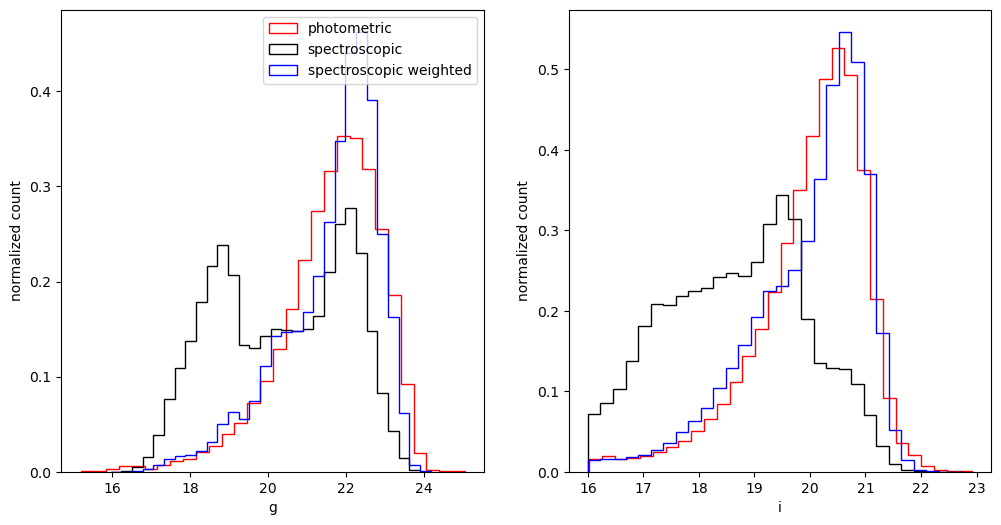

In [31]:

w = weighting(10000,test,validation)

plot_histogram_weight(validation,dr2_sample,w)


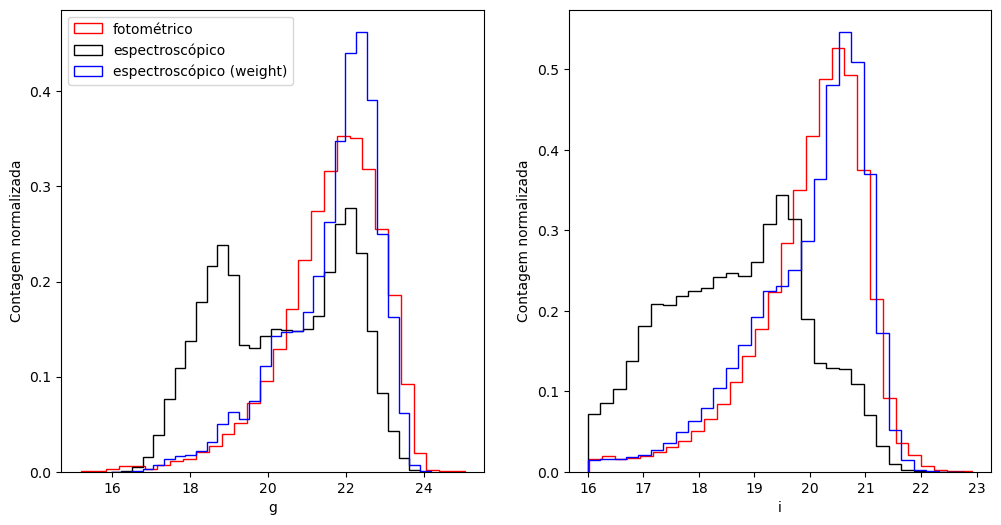

In [44]:
plot_histogram_weight(validation,dr2_sample,w)

## Plots analyses

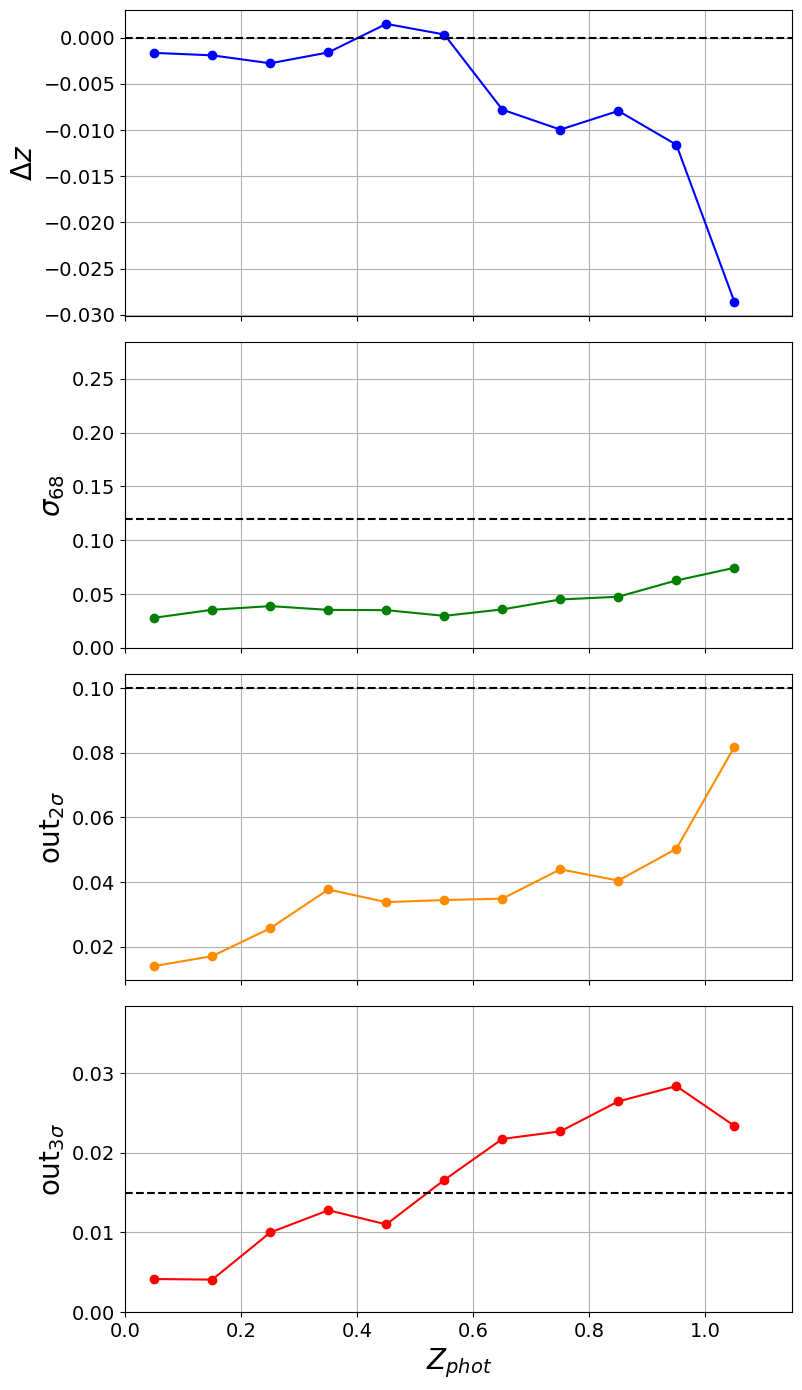

In [47]:
plot_metrics(zspec,zphot,1.2)

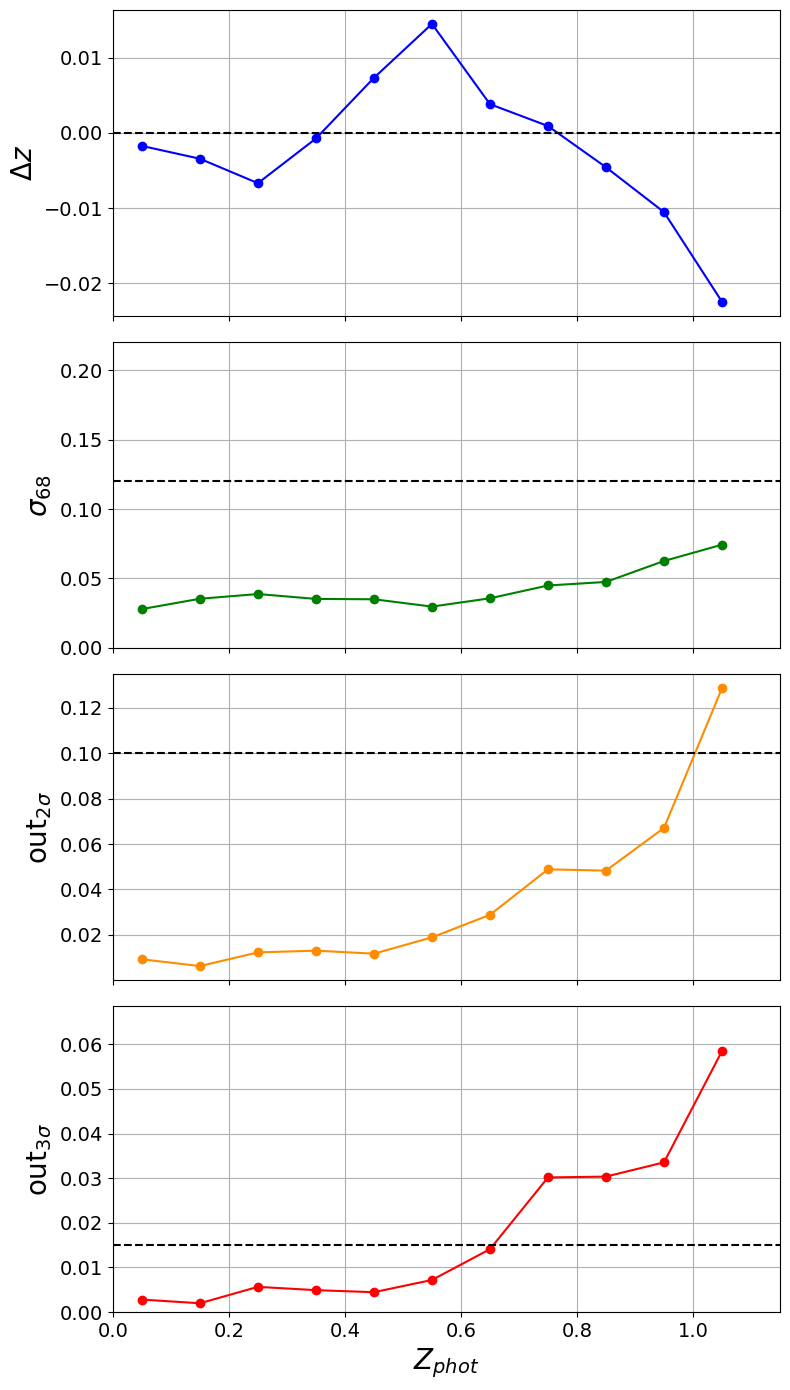

In [48]:
plot_metrics_weight(zspec,zphot,w,1.2)

In [41]:
metrics(zspec,zphot)

Mean   : -0.002148328152399171

Sigma  : 0.09604258368138334

Sigma68: 0.03468479025076168

Out_3  : 0.01394866889845369

Out_2  : 0.028953451299218873


In [42]:
metrics_weight(zspec,zphot,w)

Mean   : 0.0018920617029232203

Sigma  : 0.13921755720773535

Sigma68: 0.03468479025076168

Out_3  : 0.007193527817631117

Out_2  : 0.014715845687868644


In [ ]:
plot_scatter(zspec,zphot)